### US Presidential Election Sentiment Analysis

The 2020 US election is happening on the 3rd November
2020 and the resulting impact to the world will no doubt
be large, irrespective of which candidate is elected.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
from datetime import datetime

import warnings
warnings.simplefilter('ignore')

# Plotly libraries
import plotly
import plotly.express as px
import chart_studio.plotly as py
import plotly.offline as pyo
import plotly.graph_objs as go

import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode, plot
cf.go_offline()

from textblob import TextBlob
from wordcloud import WordCloud
import re

In [2]:
trump_df  = pd.read_csv('E:/Amit Baghel/Kumar Amit/My Projects/US_Election/hashtag_donaldtrump.csv',lineterminator='\n')
biden_df  = pd.read_csv('E:/Amit Baghel/Kumar Amit/My Projects/US_Election/hashtag_joebiden.csv',lineterminator='\n')
print('Trump dataset shape: {}'.format(trump_df.shape))
print('Biden dataset shape: {}'.format(biden_df.shape))

Trump dataset shape: (970919, 21)
Biden dataset shape: (776886, 21)


In [3]:
trump_df.describe()

,tweet_id,likes,retweet_count,user_id,user_followers_count,lat,long
count,9.709190e+05,970919.000000,970919.000000,9.709190e+05,9.709190e+05,445719.000000,445719.000000
mean,1.322494e+18,7.477011,1.698500,4.468311e+17,2.260357e+04,35.697936,-40.369638
std,2.555133e+15,158.058117,40.028419,5.544702e+17,3.042152e+05,18.823129,67.531751
min,1.316529e+18,0.000000,0.000000,5.310000e+02,0.000000e+00,-90.000000,-175.202642
25%,1.320478e+18,0.000000,0.000000,2.169326e+08,7.700000e+01,32.701939,-96.796856
50%,1.323612e+18,0.000000,0.000000,2.373392e+09,4.410000e+02,39.783730,-74.006015
75%,1.324505e+18,1.000000,0.000000,1.078344e+18,2.066000e+03,46.603354,6.776314
max,1.325589e+18,74084.000000,20491.000000,1.325581e+18,1.911533e+07,90.000000,179.048837


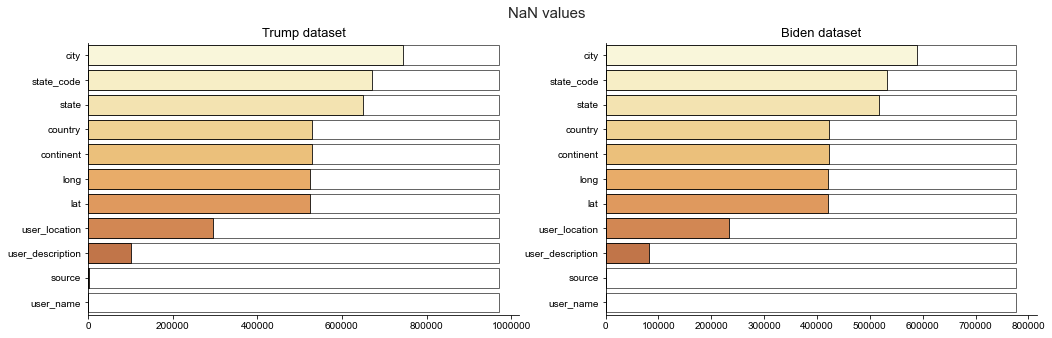

In [4]:
trump_nan = pd.Series(trump_df.isna().sum()[trump_df.isna().sum() > 0].
                      sort_values(ascending = False))
biden_nan = pd.Series(biden_df.isna().sum()[biden_df.isna().sum() > 0].
                      sort_values(ascending = False))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
sns.set_style("whitegrid")
fig.suptitle('NaN values', size = 15)

sns.barplot(y = trump_nan.index, x = [len(trump_df)] * len(trump_nan),
            edgecolor = 'black', color = 'white', alpha = 0.6, ax = ax1)
sns.barplot(y = trump_nan.index, x = trump_nan, 
            edgecolor = 'black', alpha = 0.8, ax = ax1,
            palette = sns.color_palette("YlOrBr", len(trump_nan)))
ax1.get_xaxis().get_major_formatter().set_scientific(False)
ax1.set_title('Trump dataset', size = 13)


sns.barplot(y = biden_nan.index, x = [len(biden_df)] * len(biden_nan),
            edgecolor = 'black', color = 'white', alpha = 0.6, ax = ax2)
sns.barplot(y = biden_nan.index, x = biden_nan, 
            edgecolor = 'black', alpha = 0.8, ax = ax2,
            palette = sns.color_palette("YlOrBr", len(biden_nan)))
ax2.get_xaxis().get_major_formatter().set_scientific(False)
ax2.set_title('Biden dataset', size = 13)

sns.despine()

We see that geographical information (city, state, country, etc.) is mostly unknown, so this data can't be used for analysis. We'll look only at the country feature for a small insight into the distribution of users by countries

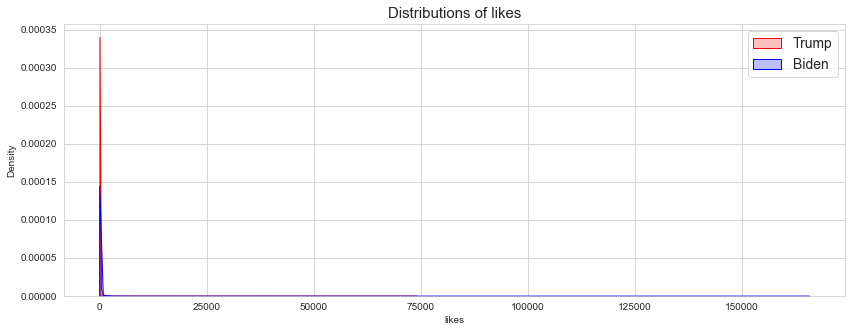

In [5]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 5))

sns.kdeplot(trump_df['likes'], label = 'Trump', shade = True, color = 'red')
sns.kdeplot(biden_df['likes'], label = 'Biden', shade = True, color = 'blue')
plt.title('Distributions of likes', size = 15)
plt.legend(prop={'size': 14})
plt.show()

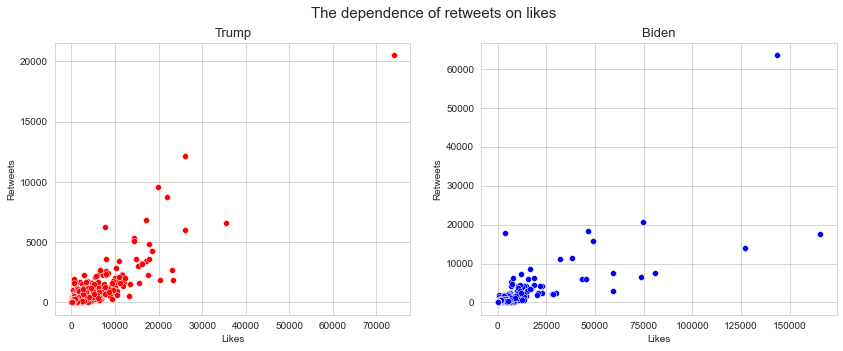

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
sns.set_style("whitegrid")
fig.suptitle("The dependence of retweets on likes", size = 15)

sns.scatterplot(x = trump_df['likes'], y = trump_df['retweet_count'],
                color = 'red', ax = ax1)
ax1.get_yaxis().get_major_formatter().set_scientific(False)
ax1.set_xlabel('Likes')
ax1.set_ylabel('Retweets')
ax1.set_title('Trump', size = 13)


sns.scatterplot(x = biden_df['likes'], y = biden_df['retweet_count'],
                color = 'blue', ax = ax2)
ax2.get_yaxis().get_major_formatter().set_scientific(False)
ax2.set_xlabel('Likes')
ax2.set_ylabel('Retweets')
ax2.set_title('Biden', size = 13)

fig.show()

In [7]:
print('Correlation between likes and retweets (Trump): {}'.
      format(trump_df['likes'].corr(trump_df['retweet_count'])))
print('Correlation between likes and retweets (Biden): {}'.
      format(biden_df['likes'].corr(biden_df['retweet_count'])))

Correlation between likes and retweets (Trump): 0.8805100805658739
Correlation between likes and retweets (Biden): 0.7936224596533263


There is a strong positive correlation between likes and retweets that looks logical.

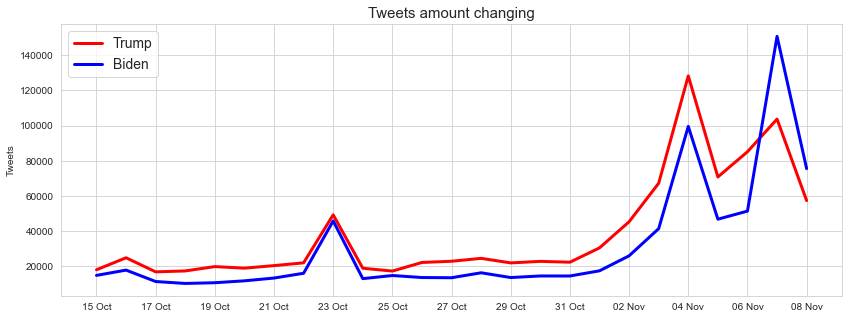

In [8]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 5))

ax = sns.lineplot(data = pd.to_datetime(trump_df.created_at).dt.date.value_counts(), 
                  label = 'Trump', color = 'red', linewidth = 3)
ax = sns.lineplot(data = pd.to_datetime(biden_df.created_at).dt.date.value_counts(), 
                  label = 'Biden', color = 'blue', linewidth = 3)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

plt.title('Tweets amount changing', size = 15)
plt.legend(prop={'size': 14})
plt.ylabel('Tweets')
plt.show()

The above chart shows that throughout the study period Donald Trump was a more popular target for tweets, but after November 6 this situation changed.

In [9]:
trump_df['country'] = trump_df['country'].replace(['United States of America', 'United States'], 'USA')
biden_df['country'] = biden_df['country'].replace(['United States of America', 'United States'], 'USA')

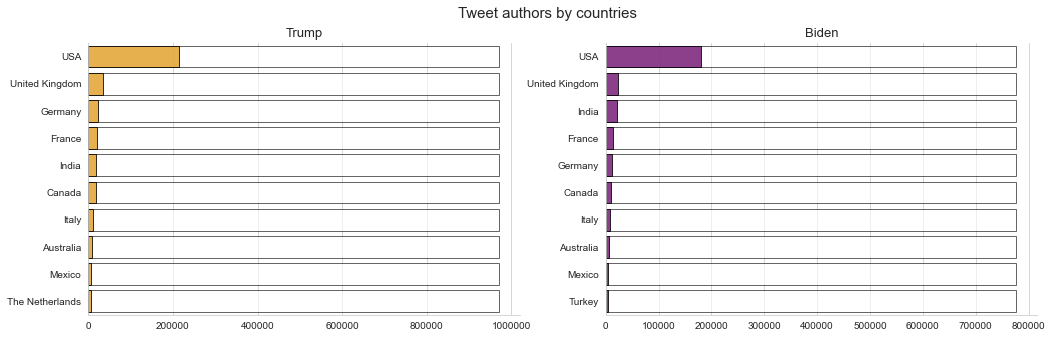

In [10]:
trump_tweets_countries = trump_df.country.value_counts()[:10]
biden_tweets_countries = biden_df.country.value_counts()[:10]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
sns.set_style("whitegrid")
fig.suptitle("Tweet authors by countries", size = 15)

sns.barplot(y = trump_tweets_countries.index, x = [len(trump_df)] * len(trump_tweets_countries),
            edgecolor = 'black', color = 'white', alpha = 0.6, ax = ax1)
sns.barplot(y = trump_tweets_countries.index, x = trump_tweets_countries, 
            edgecolor = 'black', color = 'orange', alpha = 0.8, ax = ax1)
ax1.get_xaxis().get_major_formatter().set_scientific(False)
ax1.set_xlabel('')
ax1.set_title('Trump', size = 13)


sns.barplot(y = biden_tweets_countries.index, x = [len(biden_df)] * len(biden_tweets_countries),
           edgecolor = 'black', color = 'white', alpha = 0.6, ax = ax2)
sns.barplot(y = biden_tweets_countries.index, x = biden_tweets_countries, 
            edgecolor = 'black', color = 'purple', alpha = 0.8, ax = ax2)
ax2.get_xaxis().get_major_formatter().set_scientific(False)
ax2.set_xlabel('')
ax2.set_title('Biden', size = 13)

sns.despine()

In [11]:
biden_df.loc[:,'candidate'] = 'Biden'
trump_df.loc[:,'candidate'] = 'Trump'

In [12]:
combine_df = trump_df.append(biden_df, ignore_index=True)

In [13]:
combine_df['Date'] = pd.to_datetime(combine_df['created_at'], errors='coerce')
combine_df['Month'] =combine_df['Date'].dt.month_name(locale='English')
combine_df['Days'] = combine_df['Date'].dt.day_name(locale = 'English')

### Tweets count by countries

In [14]:
def Country_tweets(country,kind):
    Data = combine_df[combine_df.country == country].groupby('candidate').tweet.count()
    Data.plot(x = 'candidate',y = "Tweets",kind = kind, title="Tweets Count in Country " + str(country))

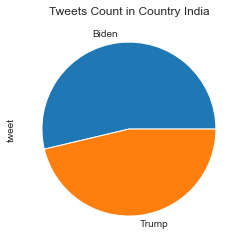

In [15]:
Country_tweets('India','pie')

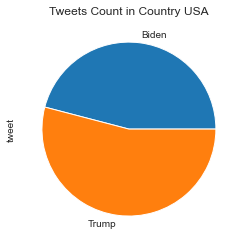

In [16]:
Country_tweets('USA','pie')

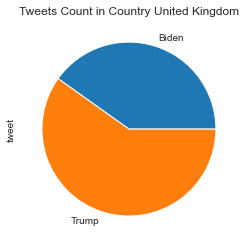

In [17]:
Country_tweets('United Kingdom','pie')

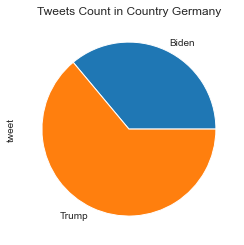

In [18]:
Country_tweets('Germany','pie')

In [19]:
combine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747805 entries, 0 to 1747804
Data columns (total 25 columns):
 #   Column                Dtype         
---  ------                -----         
 0   created_at            object        
 1   tweet_id              float64       
 2   tweet                 object        
 3   likes                 float64       
 4   retweet_count         float64       
 5   source                object        
 6   user_id               float64       
 7   user_name             object        
 8   user_screen_name      object        
 9   user_description      object        
 10  user_join_date        object        
 11  user_followers_count  float64       
 12  user_location         object        
 13  lat                   float64       
 14  long                  float64       
 15  city                  object        
 16  country               object        
 17  continent             object        
 18  state                 object        
 19  

In [20]:
class Chart_builder:
    
    def __init__(self,topic_index,number):
        super().__init__()
        self.topic_index = topic_index
        self.topics_list = ['source','country','state','continent','city']
        self.number      = number
        self.index = self.topics_list[self.topic_index]
        self.Trump_tweets_sources_x = combine_df.query('(candidate == "Trump")').groupby(by = self.index).count().tweet.sort_values(ascending = False)[:self.number].index
        
        self.Trump_tweets_sources_y = combine_df.query('(candidate == "Trump")').groupby(by = self.index).count().tweet.sort_values(ascending = False)[:self.number]
        
        self.Biden_tweets_sources_x = combine_df.query('(candidate == "Biden")').groupby(by = self.index).count().tweet.sort_values(ascending = False)[:self.number].index
        
        self.Biden_tweets_sources_y = combine_df.query('(candidate == "Biden")').groupby(by = self.index).count().tweet.sort_values(ascending = False)[:self.number]
    
    def Builder(self):
        fig = go.Figure([go.Bar(x = self.Trump_tweets_sources_x, y = self.Trump_tweets_sources_y, name = 'Trump'),
                         go.Bar(x = self.Biden_tweets_sources_x, y = self.Biden_tweets_sources_y, name = 'Biden')])
        # Customize aspect
        fig.update_layout(title_text = 'Top '+ str(self.number) + ' ' + self.index)
        fig.update_xaxes(title = 'Sources')
        fig.update_yaxes(title = 'Tweets Count')
        fig.show()

### Top 10 countries


In [21]:
# choose index for topic
topic_index = 1 # from class list its country

# number of elements in chart
number = 10 # it;s mean top five

launch = Chart_builder(topic_index,number)
launch.Builder()

### Top 10 sources

In [22]:
topic_index = 0
number = 10 
launch = Chart_builder(topic_index,number)
launch.Builder()

### Top 10 continent

In [23]:
topic_index = 3
number = 10 
launch = Chart_builder(topic_index,number)
launch.Builder()

### Top 10 cities

In [24]:
topic_index = 4
number = 10 
launch = Chart_builder(topic_index,number)
launch.Builder()

### Top 10 states

In [25]:
topic_index = 2
number = 10 
launch = Chart_builder(topic_index,number)
launch.Builder()

### Sentiment Analysis

In [26]:
def clean(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text=re.sub(r'@[A-Za-z0-9]+','',text)
    text=re.sub(r'#','',text)
    text=re.sub(r'RT[\s]+','',text)
    text=re.sub(r'[^\w]', ' ', text)
    return text

In [27]:
# create fuction to get the subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score==0:
        return 'Neutral'
    else:
        return 'Positive'

### Donald Trump Tweets Sentiment Analysis

In [28]:
trump_df['tweet']

0         #Elecciones2020 | En #Florida: #JoeBiden dice ...
1         Usa 2020, Trump contro Facebook e Twitter: cop...
2         #Trump: As a student I used to hear for years,...
3         2 hours since last tweet from #Trump! Maybe he...
4         You get a tie! And you get a tie! #Trump ‘s ra...
                                ...                        
970914    @PelleX @Mikerger @spiegelbilderz_ @BertiFranz...
970915    JOE BIDEN WHY JOE BIDEN DID WINNED ?? TRUMP TR...
970916    #AfD|ler reagieren panisch bis hysterisch auf ...
970917    @sammelbis1998 @iheartmindy @bnorthg First, yo...
970918    OK just had to do it !\n#Trump #CatapultTrump ...
Name: tweet, Length: 970919, dtype: object

In [29]:
trump_df['tweet'] = trump_df['tweet'].apply(clean)

In [30]:
trump_df['tweet']

0            en florida  joebiden dice que donaldtrump s...
1         usa   trump contro facebook e twitter  coprono...
2         trump  as a student i used to hear for years  ...
3          hours since last tweet from trump  maybe he i...
4         you get a tie  and you get a tie  trump  s ral...
                                ...                        
970914      _  _pazderski sagten sie nicht sie wären kei...
970915    joe biden why joe biden did winned    trump tr...
970916    afd ler reagieren panisch bis hysterisch auf d...
970917        first  you would need to compare that to p...
970918           ok just had to do it  trump catapulttrump 
Name: tweet, Length: 970919, dtype: object

#### Create three new columns 'Subjectivity', 'Polarity' & 'Tweet Analysis'

In [31]:
trump_df['Subjectivity'] = trump_df['tweet'].apply(getSubjectivity)
trump_df['Polarity'] = trump_df['tweet'].apply(getPolarity)
trump_df['Tweet_Analysis'] = trump_df['Polarity'].apply(getAnalysis)

In [32]:
general  = trump_df.groupby('Tweet_Analysis').Tweet_Analysis.count()
neutral  = trump_df[trump_df['Tweet_Analysis'] == 'Neutral'].Tweet_Analysis.count()
positive = trump_df[trump_df['Tweet_Analysis'] == 'Positive'].Tweet_Analysis.count()
negative = trump_df[trump_df['Tweet_Analysis'] == 'Negative'].Tweet_Analysis.count()

fig = go.Figure(data = [go.Funnelarea(labels = ["Positivity","Negativity","Neutrality"], values = [positive,negative,neutral])])
fig.update_layout(title_text ='Sentimat Analysis Tweets Donald Trump')
fig.show()

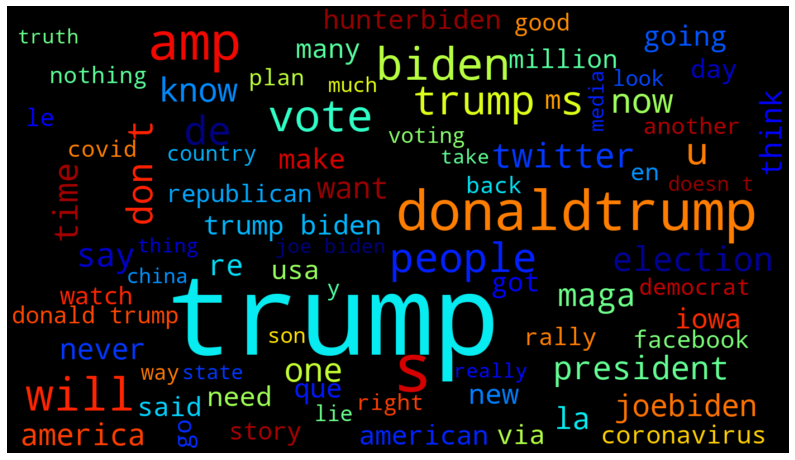

In [33]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        width=1400,
        height=800,
        random_state=5,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(14, 12))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");
word_cloud(trump_df['tweet'][0:2000])

### Joe Biden Tweets Sentiment Analysis

In [34]:
biden_df['tweet'] = biden_df['tweet'].apply(clean)

#### Create three new columns 'Subjectivity', 'Polarity' & 'Tweet Analysis'

In [35]:
biden_df['Subjectivity'] = biden_df['tweet'].apply(getSubjectivity)
biden_df['Polarity'] = biden_df['tweet'].apply(getPolarity)
biden_df['Tweet_Analysis'] = biden_df['Polarity'].apply(getAnalysis)

In [36]:
general  = biden_df.groupby('Tweet_Analysis').Tweet_Analysis.count()
neutral  = biden_df[biden_df['Tweet_Analysis'] == 'Neutral'].Tweet_Analysis.count()
positive = biden_df[biden_df['Tweet_Analysis'] == 'Positive'].Tweet_Analysis.count()
negative = biden_df[biden_df['Tweet_Analysis'] == 'Negative'].Tweet_Analysis.count()

fig = go.Figure(data = [go.Funnelarea(labels = ["Positivity","Negativity","Neutrality"], values = [positive,negative,neutral])])
fig.update_layout(title_text ='Sentimat Analysis Tweets Joe Biden')
fig.show()

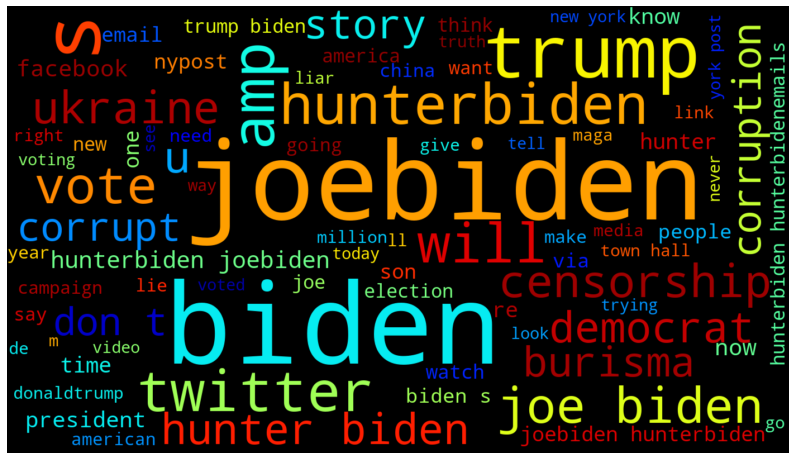

In [37]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        width=1400,
        height=800,
        random_state=5,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(14, 12))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");
word_cloud(biden_df['tweet'][0:2000])

Here we can see according to the sentiment analysis of tweets JOE BIDEN got more positive tweetes as compare Donald Trump positive tweets.